In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

X = np.zeros((10,3)) #true
X[1,0] = -sigma
X[2,0] = sigma
X[1,1] = rho
X[2,1] = -1
X[5,1] = -1
X[4,2] = 1
X[3,2] = -beta 

In [3]:
def f(p, t, sigma, rho, beta):
    x, y, z = p
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])  # Derivatives

In [4]:
state0 = [1.0, 1.0, 1.0]
Nt = 2000

dt = 0.005 + np.random.rand(Nt+1)*0.005
times = np.cumsum(dt)

# generate "observed" trajectories
traj = np.zeros((len(times),3))
traj_true = np.zeros((len(times),3))
z = state0
for k in range(len(times)):
    traj_true[k] = z 
    traj[k] = traj_true[k] + 0.1*(  1-2.0*np.random.rand(3))  # add noise
    z = z + f(traj[k], times[k], sigma, rho, beta)*dt[k]

In [5]:
# "observed" or measured derivative    
data = np.zeros((len(times),3)) 
data[0] = np.array(state0)
for k in range(1,len(times)):
    data[k-1] = (traj[k] - traj[k-1])/dt[k-1]
 
# for matrix with possible right-hand-side terms    
Z = np.zeros((len(times),10))
for k in range(len(times)):
    x = traj[k,0]
    y = traj[k,1]
    z = traj[k,2]
    Z[k] = np.array([ 10, x, y, z, x*y, x*z, y*z,x*x,y*y,z*z ])

In [6]:
ZZ=np.dot(Z.T,Z) 
# sparse optimization
Xpred = np.dot(np.linalg.inv( ZZ ),  np.dot( Z.T, data  )) 
for k in range(3):
    for it in range(5):
        ind = np.argwhere(np.abs(Xpred[:,k])>0.1).T[0]
        ZZsub=ZZ[ind,:] # construct sub-matrix
        ZZsub=ZZsub[:,ind]
        Xpred[:,k] = Xpred[:,k]*0
        Xpred[ind,k] = np.dot(np.linalg.inv( ZZsub ),  np.dot( Z.T, data[:,k]  )[ind])  

Predicted with misfit =  0.13109378723964232


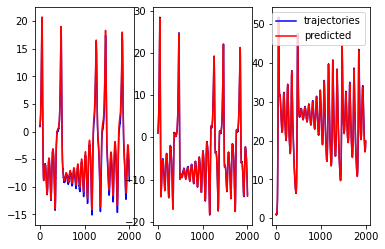

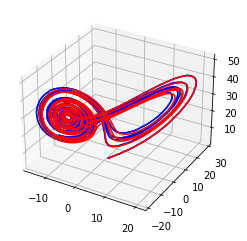

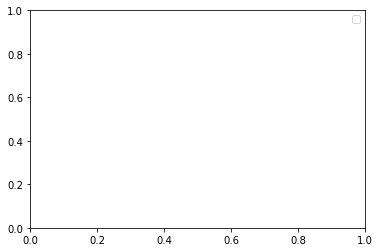

In [7]:
misfit = np.linalg.norm(Xpred - X)
print('Predicted with misfit = ', misfit)


Ypred = np.dot(Z,Xpred)
Tpred = np.zeros((len(times),3))
Tpred[0] = state0
for k in range(1,len(times)):
    Tpred[k] = Tpred[k-1] + Ypred[k]*(times[k]-times[k-1])
    
plt.figure()
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(traj[:,k],'b')
    plt.plot(Tpred[:,k],'r')
plt.legend(['trajectories','predicted'])    
    

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(traj_true[:, 0], traj_true[:, 1], traj_true[:, 2],'g')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2],'b')
ax.plot(Tpred[:, 0], Tpred[:, 1], Tpred[:, 2],'r')
plt.draw()
plt.show()
plt.legend(['trajectories','predicted'])    

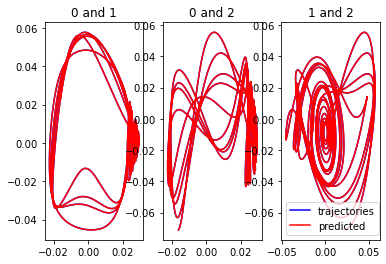

In [8]:
T = traj.shape[0] - 100
H = np.zeros((100,T))
for k in range(H.shape[0]):
    H[k,:] = traj[k:k+T,0].T # take x
u, s, vh = np.linalg.svd(H, full_matrices=True)   

H = np.zeros((100,T))
for k in range(H.shape[0]):
    H[k,:] = traj_true[k:k+T,0].T # take x
ut, st, vht = np.linalg.svd(H, full_matrices=True) 

plt.figure() 
plt.subplot(1,3,1)
plt.plot(vht[0,:],vht[1,:],'b')
plt.plot(vh[0,:],vh[1,:],'r')
plt.title('0 and 1')
plt.subplot(1,3,2)
plt.plot(vht[0,:],vht[2,:],'b')
plt.plot(vh[0,:],vh[2,:],'r')
plt.title('0 and 2')
plt.subplot(1,3,3)
plt.plot(vht[1,:],vht[2,:],'b')
plt.plot(vh[1,:],vh[2,:],'r')
plt.title('1 and 2')
plt.legend(['trajectories','predicted'])  